In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyperopt import fmin, tpe, Trials
from openml import datasets, tasks, flows, config

from openmlstudy14.preprocessing import ConditionalImputer
from workloadoptimization.essentials import Component, ExperimentParser
from workloadoptimization.hyperopt_helper import TrialConverter
from workloadoptimization.openml_helper import OpenMLReader
from workloadoptimization.search_space import SearchSpaceDesigner
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

## Warmstarting Hyperparameter Search
In another notebook [Hyperparameter Warmstarting](hyper-parameter-optimization-warm-starting.ipynb) we investigated the effect of warmstarting on one pipeline and task (Task 31 and Pipeline 7707).
In this notebook, we generalize the code to arbitrary tasks and pipelines.
The process is as follows:
- The input is one task and a list of flow ids. 
- We retrieve the flow and task and all the runs and evaluations of the flows on the task
- For every flow, we extract the variable hyperparameters and estimate the search space (for now this would be static function)
- We warm start the trial object of hyperopt.
- For every flow, compare the warm starting vs no warm starting

Lastly, we should extract the reusable code (hyperparameter extraction and warmstarting) to a separate file.

In [2]:
flow_ids = [8568, 8353, 8315, 7707]
task_ids = [31]

In [3]:
# load the dataset
task = tasks.get_task(task_id=31)
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices,test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
target=dataset.default_target_attribute,
return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [4]:
def extractExperiments(filePath, taskIds, flowIds):
    openMLReader = OpenMLReader()
    if os.path.isfile(filePath):
        return pd.read_pickle(filePath)
    frames = []
    for t in taskIds:
        for f in flowIds:
            frames.append(openMLReader.getTopRuns(-1,f,t))
    Experiments = pd.concat(frames).reset_index(drop=True)
    Experiments.to_pickle(filePath)
    return Experiments

# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extractExperiments('meta/hyper-opt-experiment-31-all', task_ids, flow_ids)

In [5]:
OPENML_FLOWS = {}
FLOW_IDS = Experiments.flow_id.unique()
for f in FLOW_IDS:
    try:
        fl = flows.get_flow(f)
        OPENML_FLOWS[f] = fl 
    except:
        print 'error for {}'.format(f)
parser = ExperimentParser()
experimentObjects = parser.extractOpenMLFlows(Experiments, OPENML_FLOWS)

/usr/local/lib/python2.7/site-packages/openml-0.7.0-py2.7.egg/openml/flows/sklearn_converter.py:401: UserWarning: Cannot create model arbok.preprocessing.ConditionalImputer for flow.
  warnings.warn('Cannot create model %s for flow.' % model_name)


AttributeError: ExperimentParser instance has no attribute 'extractOpenMLFlows'

In [ ]:
designer = SearchSpaceDesigner(experimentObjects)
constantSpace = designer.getConstantParams()
hyperOptSpace = designer.getSearchSpace()

In [ ]:
flow = flows.get_flow(flow_id=8568)
# Hack for the non existing arbok.preprocessing.ConditionalImputer Class
flow.components['conditionalimputer'].class_name = 'hyperimp.utils.preprocessing.ConditionalImputer2'
pipeline8568 = flows.flow_to_sklearn(flow)

flow = flows.get_flow(flow_id=8353)
pipeline8353 = flows.flow_to_sklearn(flow)

flow = flows.get_flow(flow_id=8315)
pipeline8315 = flows.flow_to_sklearn(flow)

flow = flows.get_flow(flow_id=7707)
# Hack for changing the sklearn version dependecy as it does not affect the pipelines
flow.dependencies = u'sklearn==0.19.1\nnumpy>=1.6.1\nscipy>=0.9'
for v in flow.components.itervalues():
    v.dependencies = u'sklearn==0.19.1\nnumpy>=1.6.1\nscipy>=0.9'
pipeline7707 = flows.flow_to_sklearn(flow)

In [ ]:
# set the constant parameters and define the objective function
pipeline8568.set_params(**constantSpace[8568])
pipeline8353.set_params(**constantSpace[8353])
pipeline8315.set_params(**constantSpace[8315])
pipeline7707.set_params(**constantSpace[7707])


def objective8568(params):
    pipeline8568.set_params(**params)
    try:
        pipeline8568.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
        return 1.0
    return 1 - pipeline8568.score(X_test, y_test)


def objective8353(params):
    # seems when tol is big (greater than 1) scikit learn throws an exception
    # I couldn't find a way to cap a value in the search space of hyperopt, 
    # this is the alternative solution
    if params['clf__tol'] > 0.2:
        params['clf__tol'] = 0.2
    elif params['clf__tol'] < 1.0e-5:
        params['clf__tol'] = 1.0e-5
    pipeline8353.set_params(**params)
    try:
        pipeline8353.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
        return 1.0
    return 1 - pipeline8353.score(X_test, y_test)


def objective8315(params):
    pipeline8315.set_params(**params)
    try:
        pipeline8315.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
        return 1.0
    return 1 - pipeline8315.score(X_test, y_test)


def objective7707(params):
    # seems when tol is big (greater than 1) scikit learn throws an exception
    # I couldn't find a way to cap a value in the search space of hyperopt, 
    # this is the alternative solution
    if params['classifier__tol'] > 0.2:
        params['classifier__tol'] = 0.2
    elif params['classifier__tol'] < 1.0e-5:
        params['classifier__tol'] = 1.0e-5
    pipeline7707.set_params(**params)
    try:
        pipeline7707.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
        return 1.0
    return 1 - pipeline7707.score(X_test, y_test)


In [ ]:
def hyperparam_experiment(trialsDatabase, numberOfExperiments, numberOfEvals, space, objective):
    losses = np.empty([0, numberOfEvals])
    INITIAL_SIZE = len(trialsDatabase.trials)

    for i in range(numberOfExperiments):
        print '.',
        trials = Trials()
        trials.insert_trial_docs(trialsDatabase.trials)
        trials.refresh()
    
        fmin(objective, space, algo=tpe.suggest, max_evals=INITIAL_SIZE + numberOfEvals, trials=trials)

        newTrials = Trials()
        newTrials.insert_trial_docs(trials.trials[INITIAL_SIZE:])
        newTrials.refresh()
        losses = np.insert(losses, i, np.array(newTrials.losses()), 0)
    return losses

In [ ]:
trialConverter = TrialConverter()

warmTrials8568 = trialConverter.trialsFromExperimentObjects(hyperOptSpace[8568], getObjectsForPipeline(8568))
print 'Size of history: {}'.format(len(warmTrials8568.trials))
warmTrials8353 = trialConverter.trialsFromExperimentObjects(hyperOptSpace[8353], getObjectsForPipeline(8353))
print 'Size of history: {}'.format(len(warmTrials8353.trials))
warmTrials8315 = trialConverter.trialsFromExperimentObjects(hyperOptSpace[8315], getObjectsForPipeline(8315))
print 'Size of history: {}'.format(len(warmTrials8315.trials))
warmTrials7707 = trialConverter.trialsFromExperimentObjects(hyperOptSpace[7707], getObjectsForPipeline(7707))
print 'Size of history: {}'.format(len(warmTrials7707.trials))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

NUMBER_OF_EXPERIMENTS = 10
NUMBER_OF_TRIALS = 50

In [ ]:
tpe.DEFAULT_LF = 0

print 'Pipeline 8568'
warmLosses8568 = hyperparam_experiment(warmTrials8568, NUMBER_OF_EXPERIMENTS, NUMBER_OF_TRIALS, hyperOptSpace[8568], objective8568)

print ''
print 'Pipeline 8353'
warmLosses8353 = hyperparam_experiment(warmTrials8353, NUMBER_OF_EXPERIMENTS, NUMBER_OF_TRIALS, hyperOptSpace[8353], objective8353)

print ''
print 'Pipeline 8315'
warmLosses8315 = hyperparam_experiment(warmTrials8315, NUMBER_OF_EXPERIMENTS, NUMBER_OF_TRIALS, hyperOptSpace[8315], objective8315)

print ''
print 'Pipeline 7707'
warmLosses7707 = hyperparam_experiment(warmTrials7707, NUMBER_OF_EXPERIMENTS, NUMBER_OF_TRIALS, hyperOptSpace[7707], objective7707)

In [ ]:
tpe.DEFAULT_LF = 25

print 'Pipeline 8568'
coldTrials = Trials() 
coldLosses8568 = hyperparam_experiment(coldTrials, NUMBER_OF_EXPERIMENTS, NUMBER_OF_TRIALS, hyperOptSpace[8568], objective8568)

print ''
print 'Pipeline 8353'
coldTrials = Trials()   
coldLosses8353 = hyperparam_experiment(coldTrials, NUMBER_OF_EXPERIMENTS, NUMBER_OF_TRIALS, hyperOptSpace[8353], objective8353)

print ''
print 'Pipeline 8315'
coldTrials = Trials()   
coldLosses8315 = hyperparam_experiment(coldTrials, NUMBER_OF_EXPERIMENTS, NUMBER_OF_TRIALS, hyperOptSpace[8315], objective8315)

print ''
print 'Pipeline 7707'
coldTrials = Trials()   
coldLosses7707 = hyperparam_experiment(coldTrials, NUMBER_OF_EXPERIMENTS, NUMBER_OF_TRIALS, hyperOptSpace[7707], objective7707)

In [ ]:
def meltLosses(warmLosses, coldLosses):
    dfDict = {}
    dfDict['Warm'] = np.minimum.accumulate(warmLosses, axis=1).flatten()  
    dfDict['Cold'] = np.minimum.accumulate(coldLosses, axis=1).flatten()  
    dfDict['Trial'] = range(NUMBER_OF_TRIALS) * NUMBER_OF_EXPERIMENTS
    ExperimentAverages = pd.DataFrame(dfDict)
    melted = ExperimentAverages.melt('Trial', var_name='Warmstarting', value_name='Loss')
    return melted

In [6]:
df8568 = meltLosses(warmLosses8568, coldLosses8568)
df8353 = meltLosses(warmLosses8353, coldLosses8353)
df8315 = meltLosses(warmLosses8315, coldLosses8315)
df7707 = meltLosses(warmLosses7707, coldLosses7707)

NameError: name 'meltLosses' is not defined

NameError: name 'df8353' is not defined

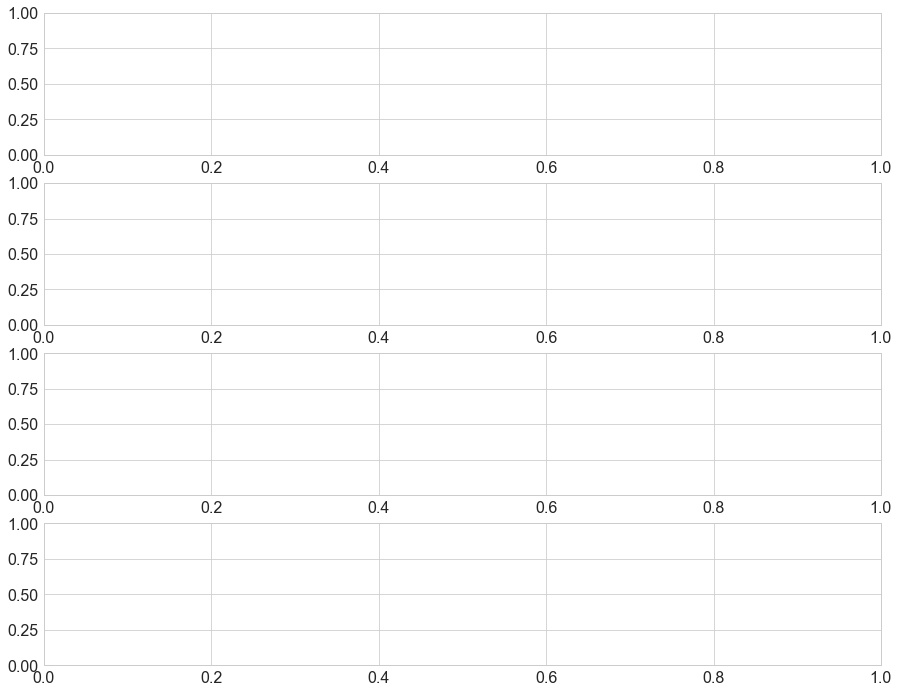

In [7]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
axes = [ax1,ax2,ax3, ax4]
dfs = [df8353, df8315, df7707, df8568]
labelsize = 22
titlesize = 26
pipelines = ['8353','8315','7707', '8568']
for i in range(len(pipelines)):
    g = sns.factorplot(data=dfs[i], 
                       x = 'Trial', 
                       y = 'Loss', 
                       hue = 'Warmstarting', 
                       #estimator = np.average,
                       #ci = None,
                       #scale = 0.8,
                       size=8, aspect=2, ax=axes[i], legend=False, legend_out=False)
    axes[i].set_ylabel('Loss', fontsize=labelsize)
    axes[i].set_xlabel('Trial', fontsize=labelsize)
    axes[i].set(xticks=np.arange(10, NUMBER_OF_TRIALS+1, 10)-1)
    axes[i].set_title('Pipeline {}'.format(pipelines[i]), fontsize = titlesize)
    axes[i].set_xticklabels(np.arange(10, NUMBER_OF_TRIALS+1, 10), fontsize = labelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=labelsize)
    plt.setp(axes[i].collections, sizes=[0])
    #axes[i].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.,)
    axes[i].legend_.remove()
    plt.close(g.fig)
    
legend = axes[-1].legend(title = 'Warmstarting',
           bbox_to_anchor=(0.5, -.32),
           loc='upper center',
           borderaxespad=0.,
           fancybox = True,
           shadow=True,
           ncol = 2, 
           fontsize = titlesize)
plt.setp(legend.get_title(),fontsize = titlesize)
plt.tight_layout()
#plt.savefig('figures/paper/task31-cold-warm-trials.eps', format='eps', dpi=1000, bbox_inches='tight')

In [ ]:
def getBestLoss(warm, cold):
    bestLoss = min(np.min(warm),np.min(cold))
    warmCount = len(np.where(warm == bestLoss)[0])
    coldCount = len(np.where(cold == bestLoss)[0])
    return bestLoss, warmCount, coldCount

In [ ]:
losses = dict()
b,w,c = getBestLoss(warmLosses7707, coldLosses7707)
losses[7707] = {'Best':b,'Warm':w,'Cold':c}

b,w,c = getBestLoss(warmLosses8353, coldLosses8353)
losses[8353] = {'Best':b,'Warm':w,'Cold':c}

b,w,c = getBestLoss(warmLosses8315, coldLosses8315)
losses[8315] = {'Best':b,'Warm':w,'Cold':c}

b,w,c = getBestLoss(warmLosses8568, coldLosses8568)
losses[8568] = {'Best':b,'Warm':w,'Cold':c}

BestErrors = pd.DataFrame.from_dict(losses, orient='index')
BestErrors = BestErrors[['Best', 'Warm', 'Cold']]

In [ ]:
BestErrors.to_csv('figures/paper/table-task31-cold-warm-trials.csv')